   
# Resume Parse
## 1. Import packages
  

In [23]:
import re
import string
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score


# supress sklearn warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline

## 2. Wrangle data
1. Read data
2. Clean data
    1. Remove stops
    2. Remove punctuation
3. Stem data
4. Add features
    1. Line length: total non-whitespace characters
    2. Verb percentage: portion of verbs per line
    3. Stop word percentage: portion of stop words per line
    4. Punctuation percentage: portion of punction per line

In [2]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
verb_tags = ['VB','VBG','VBD', 'VBN','VBN-HL','VERB']
data = pd.read_csv('./dev/raw_in.csv', sep=',')

data


,line,label
0,Bernard Foster,Name
1,"Smyrna, GA 30082 ...",Contact
2,Bernard Foster is a Solutions Architect with a...,Summary
3,Professional Experience,Heading
4,"Research 1, Inc S...",Unknown
...,...,...
1001,November 2003 - March 2007,Date
1002,Earned $2344.00 in cash awards and 16 vacation...,Bullet
1003,EDUCATION,Heading
1004,"Bachelor of Science, Business Information Syst...",Degree


## Clean and adjust data

In [3]:
def clean_text(text):
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+',text)
    text = [word for word in tokens if word not in stopwords]
    return text

def get_stems(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

def count_verbs(pos_tags: list) -> int:
    count = sum([1 for pair in pos_tags if pair[1] in verb_tags])
    return round(count/(len(pos_tags)),3)*100

def count_stopwords(line: str) -> int:
    count = sum([1 for word in nltk.word_tokenize(line) if word in nltk.corpus.stopwords.words('english')])
    return round(count/(len(line) - line.count(' ')),3)*100

def count_punct(line: str) -> int:
    count = sum([1 for char in line if char in string.punctuation])
    return round(count/(len(line) - line.count(' ')), 3)*100

data['line_nostop'] = data['line'].apply(lambda x: clean_text(x.lower()))

data['line_stemmed'] = data['line_nostop'].apply(lambda x: get_stems(x))

data['line_length'] = data['line'].apply(lambda x: len(x) - x.count(' '))

data['tagged_line'] = data['line'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

data['verb_percentage'] = data['tagged_line'].apply(lambda x: count_verbs(x))

data['stopword_percentage'] = data['line'].apply(lambda x: count_stopwords(x))

data['punctuation_percentage'] = data['line'].apply(lambda x: count_punct(x))

data['is_bullet'] = data['label'].apply(lambda x: 1 if x == 'Bullet' else 0)

data

,line,label,line_nostop,line_stemmed,line_length,tagged_line,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
0,Bernard Foster,Name,"[bernard, foster]","[bernard, foster]",13,"[(Bernard, NNP), (Foster, NNP)]",0.0,0.0,0.0,0
1,"Smyrna, GA 30082 ...",Contact,"[smyrna, ga, 30082, cell, 404, 6616742, bernar...","[smyrna, ga, 30082, cell, 404, 6616742, bernar...",57,"[(Smyrna, NNP), (,, ,), (GA, NNP), (30082, CD)...",0.0,0.0,10.5,0
2,Bernard Foster is a Solutions Architect with a...,Summary,"[bernard, foster, solutions, architect, vast, ...","[bernard, foster, solut, architect, vast, amou...",698,"[(Bernard, NNP), (Foster, NNP), (is, VBZ), (a,...",4.1,4.9,2.7,0
3,Professional Experience,Heading,"[professional, experience]","[profession, experi]",22,"[(Professional, JJ), (Experience, NN)]",0.0,0.0,0.0,0
4,"Research 1, Inc S...",Unknown,"[research, 1, inc, salesforce, administratorco...","[research, 1, inc, salesforc, administratorcon...",67,"[(Research, NN), (1, CD), (,, ,), (Inc, NNP), ...",10.0,1.5,3.0,0
...,...,...,...,...,...,...,...,...,...,...
1001,November 2003 - March 2007,Date,"[november, 2003, march, 2007]","[novemb, 2003, march, 2007]",22,"[(November, NNP), (2003, CD), (-, :), (March, ...",0.0,0.0,4.5,0
1002,Earned $2344.00 in cash awards and 16 vacation...,Bullet,"[earned, 234400, cash, awards, 16, vacation, h...","[earn, 234400, cash, award, 16, vacat, hour, j...",62,"[(Earned, VBD), ($, $), (2344.00, CD), (in, IN...",7.1,4.8,4.8,1
1003,EDUCATION,Heading,[education],[educ],9,"[(EDUCATION, NN)]",0.0,0.0,0.0,0
1004,"Bachelor of Science, Business Information Syst...",Degree,"[bachelor, science, business, information, sys...","[bachelor, scienc, busi, inform, system, belle...",73,"[(Bachelor, NN), (of, IN), (Science, NNP), (,,...",0.0,1.4,5.5,0


In [4]:
# Data types
data.dtypes

line                       object
label                      object
line_nostop                object
line_stemmed               object
line_length                 int64
tagged_line                object
verb_percentage           float64
stopword_percentage       float64
punctuation_percentage    float64
is_bullet                   int64
dtype: object

In [5]:
# See distrobution of target variable ('Bullet')
data['is_bullet'].value_counts()

0    619
1    387
Name: is_bullet, dtype: int64

In [6]:
# Get numeric features only by dropping categorical features.


cat_feat = ['line', 'label', 'line_nostop','line_stemmed','tagged_line']
numeric_only = data.drop(cat_feat, axis=1)
numeric_only

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
0,13,0.0,0.0,0.0,0
1,57,0.0,0.0,10.5,0
2,698,4.1,4.9,2.7,0
3,22,0.0,0.0,0.0,0
4,67,10.0,1.5,3.0,0
...,...,...,...,...,...
1001,22,0.0,0.0,4.5,0
1002,62,7.1,4.8,4.8,1
1003,9,0.0,0.0,0.0,0
1004,73,0.0,1.4,5.5,0


In [7]:
# Look at general distrobution of these features
numeric_only.describe()

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
count,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000
mean,67.814115,4.668787,2.017097,3.751690,0.384692
std,107.621847,9.020396,2.548894,8.561202,0.486764
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,0.000000,0.000000,2.100000,0.000000
75%,80.000000,7.400000,3.800000,4.600000,1.000000
max,1682.000000,100.000000,20.000000,100.000000,1.000000


In [8]:
# Look at the correlation matrix. The best features have a strong correlation
# with the target variable only. If there is a strong correlation between other
# features, it can confuse the model. This must still be tested, but looking
# at a simple correlation matrix is helpful.

numeric_only.corr()

,line_length,verb_percentage,stopword_percentage,punctuation_percentage,is_bullet
line_length,1.000000,0.176698,0.282802,0.017763,0.345631
verb_percentage,0.176698,1.000000,0.319386,-0.119124,0.310572
stopword_percentage,0.282802,0.319386,1.000000,-0.148704,0.556881
punctuation_percentage,0.017763,-0.119124,-0.148704,1.000000,-0.112462
is_bullet,0.345631,0.310572,0.556881,-0.112462,1.000000


In [9]:
# Group by the two levels of the 'is_bullet' column
# Look at the distribution of each feature for bullets and non-bullets
# Run a t-test on the two distributions to see if the difference
#    is statistacally significant

def describe_cont_feature(feature):
    print('\n*** Results for {}'.format(feature))
    print(data.groupby('is_bullet')[feature].describe())
    print(ttest(feature))
    
def ttest(feature):
    bullet = data[data['is_bullet']==1][feature]
    not_bullet = data[data['is_bullet']==0][feature]
    tstat, pval = stats.ttest_ind(bullet, not_bullet, equal_var=False)
    print('t-statistic: {:.1f}, p-value: {:.3}'.format(tstat,pval))

In [14]:
# Look at the distribution of each feature at each level of the target variable
features = list(numeric_only.columns.values)

for feature in features:
    describe_cont_feature(feature)


*** Results for line_length
           count        mean         std  min   25%   50%    75%     max
is_bullet                                                               
0          619.0   38.416801   52.680027  3.0  14.0  24.0   44.0   698.0
1          387.0  114.834625  148.696751  6.0  53.0  81.0  108.0  1682.0
t-statistic: 9.7, p-value: 1.93e-20
None

*** Results for verb_percentage
           count      mean       std  min  25%  50%    75%    max
is_bullet                                                        
0          619.0  2.454766  9.119343  0.0  0.0  0.0   0.00  100.0
1          387.0  8.210078  7.633521  0.0  0.0  7.4  12.55   50.0
t-statistic: 10.8, p-value: 1.3e-25
None

*** Results for stopword_percentage
           count      mean       std  min  25%  50%   75%   max
is_bullet                                                      
0          619.0  0.895315  2.107237  0.0  0.0  0.0  0.00  20.0
1          387.0  3.811370  2.135494  0.0  2.6  3.8  5.05  12.2
t-stati

## 3. Test Features

### Testing Line Length

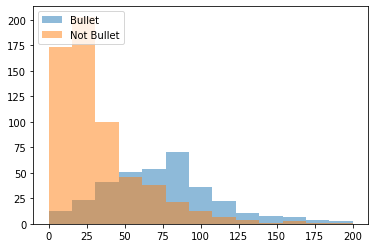

In [19]:
bins = np.linspace(0, 200, 14)

pyplot.hist(numeric_only[numeric_only['is_bullet']==1]['line_length'], bins, alpha=0.5, label='Bullet')
pyplot.hist(numeric_only[numeric_only['is_bullet']==0]['line_length'], bins, alpha=0.5, label='Not Bullet')
pyplot.legend(loc='upper left')
pyplot.show()

### Testing verb percentage 

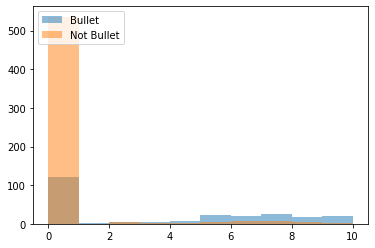

In [20]:
bins = np.linspace(0, 10, 11)

pyplot.hist(numeric_only[numeric_only['is_bullet']==1]['verb_percentage'], bins, alpha=0.5, label='Bullet')
pyplot.hist(numeric_only[numeric_only['is_bullet']==0]['verb_percentage'], bins, alpha=0.5, label='Not Bullet')
pyplot.legend(loc='upper left')
pyplot.show()

### Testing stop word percentage 

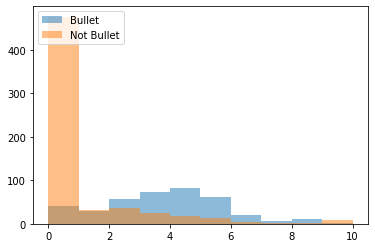

In [21]:
bins = np.linspace(0, 10, 11)

pyplot.hist(numeric_only[numeric_only['is_bullet']==1]['stopword_percentage'], bins, alpha=0.5, label='Bullet')
pyplot.hist(numeric_only[numeric_only['is_bullet']==0]['stopword_percentage'], bins, alpha=0.5, label='Not Bullet')
pyplot.legend(loc='upper left')
pyplot.show()

### Testing punctuation percentage 

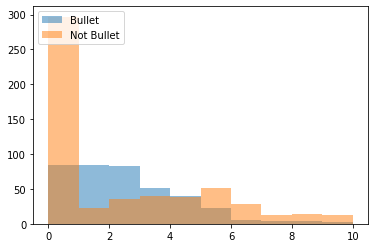

In [22]:
bins = np.linspace(0, 10, 11)

pyplot.hist(numeric_only[numeric_only['is_bullet']==1]['punctuation_percentage'], bins, alpha=0.5, label='Bullet')
pyplot.hist(numeric_only[numeric_only['is_bullet']==0]['punctuation_percentage'], bins, alpha=0.5, label='Not Bullet')
pyplot.legend(loc='upper left')
pyplot.show()

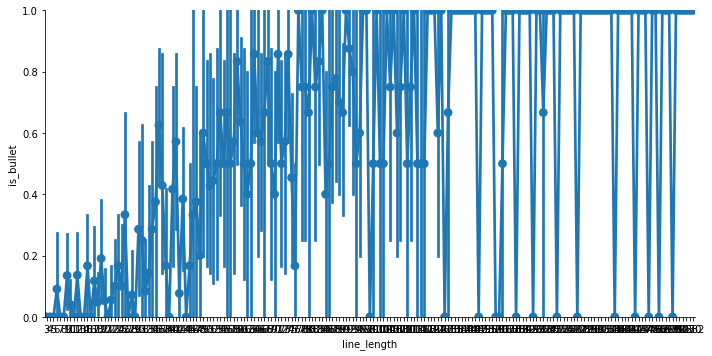

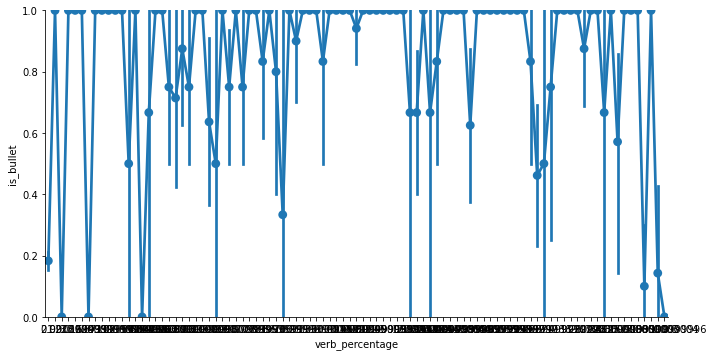

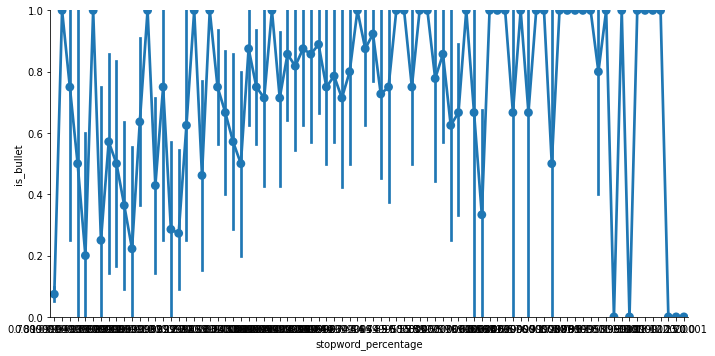

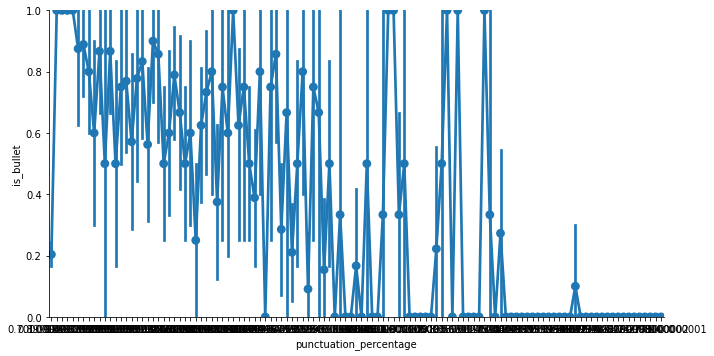

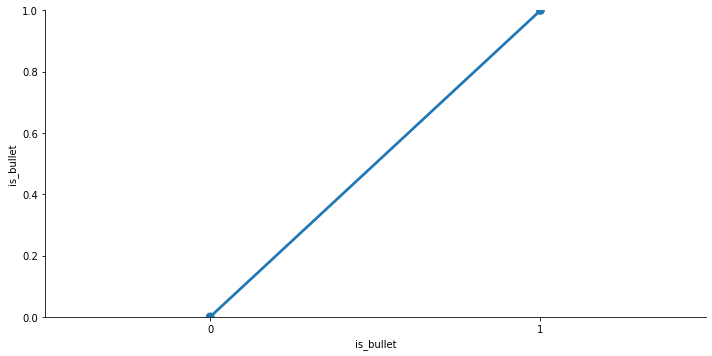

In [27]:
# Generate categorical plots for ordinal features
for col in features:
    sns.catplot(x=col, y='is_bullet', data=numeric_only, kind='point', aspect=2,)
    pyplot.ylim(0, 1)

## 4. Split into training, validation, and test sets

In [ ]:
features = data.drop('label', axis=1)
labels = data['label']


X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



In [ ]:
print(len(labels), len(y_train), len(y_val), len(y_test))

## 5. Vectorize text

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['line'])

tfidf_train = tfidf_vect_fit.transform(X_train['line'])
tfidf_test = tfidf_vect_fit.transform(X_test['line'])

X_train_vect = pd.concat([X_train[['line_length','verb_percentage','stopword_percentage','punctuation_percentage']].reset_index(drop=True),
                         pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['line_length','verb_percentage','stopword_percentage','punctuation_percentage']].reset_index(drop=True),
                         pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

## 5. Final model evaluation

In [ ]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, average='micro')
print('Fit time: {} | Predict time: {}\n Precision: {}\n Recall: {}\n Accuracy: {}\n Fscore: {}'.format(
round(fit_time, 3),
round(pred_time, 3),
np.round(precision, 3),
np.round(recall, 3),
round((y_pred==y_test).sum()/len(y_pred),3),
round(fscore, 3)))

In [ ]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, average='micro')
print('Fit time: {} | Predict time: {}\n Precision: {}\n Recall: {}\n Accuracy: {}\n Fscore: {}'.format(
round(fit_time, 3),
round(pred_time, 3),
np.round(precision, 3),
np.round(recall, 3),
round((y_pred==y_test).sum()/len(y_pred),3),
round(fscore, 3)))